In [1]:
import tensorflow as tf
tf.enable_eager_execution()

##Use data from tensorflow_datasets library

In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4K57FA/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4K57FA/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4K57FA/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


##Convert data into training and testing set in numpy list format

In [0]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [4]:
print("total training sentences:", len(training_sentences))
print("total testing sentences:", len(testing_sentences))

print("\none example of training sentence: ")
print(training_sentences[0])
print("the label is:", training_labels_final[0])
print("\nanother example of training sentence: ")
print(training_sentences[3])
print("the label is:", training_labels_final[3])

total training sentences: 25000
total testing sentences: 25000

one example of training sentence: 
b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
the label is: 0

another example of training sentence: 
b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend

##Set some parameters here and tokenize the sentences

In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
#encode and pad the training sentences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)
#encode and pad the testing sentences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

print(len(word_index))

86539


In [9]:
print(padded)
print(training_labels_final)

[[   0    0   59 ...  874  145   10]
 [   0    0    0 ...   32   31   47]
 [   1 6175    2 ...  564    5  746]
 ...
 [7629   37   11 ...  168    6   29]
 [2677   11  216 ...  249   96   45]
 [3875    5   31 ...   17    1   11]]
[0 0 0 ... 0 0 1]


In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(training_sentences[5])
print("=======After encode and decode=======")
print(decode_review(padded[5]))

b"This is a film which should be seen by anybody interested in, effected by, or suffering from an eating disorder. It is an amazingly accurate and sensitive portrayal of bulimia in a teenage girl, its causes and its symptoms. The girl is played by one of the most brilliant young actresses working in cinema today, Alison Lohman, who was later so spectacular in 'Where the Truth Lies'. I would recommend that this film be shown in all schools, as you will never see a better on this subject. Alison Lohman is absolutely outstanding, and one marvels at her ability to convey the anguish of a girl suffering from this compulsive disorder. If barometers tell us the air pressure, Alison Lohman tells us the emotional pressure with the same degree of accuracy. Her emotional range is so precise, each scene could be measured microscopically for its gradations of trauma, on a scale of rising hysteria and desperation which reaches unbearable intensity. Mare Winningham is the perfect choice to play her m

##Build your model

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # try if it gets better accuracy
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # try if it gets better accuracy
    tf.keras.layers.Dense(24, activation='relu'),  #6, 24
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 174,129
Trainable params: 174,129
Non-trainable params: 0
_________________________________________________________________


##Train the model

In [0]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 403s 16ms/sample - loss: 0.4703 - acc: 0.7598 - val_loss: 0.3480 - val_acc: 0.8466
Epoch 2/10
25000/25000 [==============================] - 399s 16ms/sample - loss: 0.2929 - acc: 0.8800 - val_loss: 0.3505 - val_acc: 0.8460
Epoch 3/10
25000/25000 [==============================] - 397s 16ms/sample - loss: 0.2345 - acc: 0.9086 - val_loss: 0.3759 - val_acc: 0.8398
Epoch 4/10
25000/25000 [==============================] - 395s 16ms/sample - loss: 0.1810 - acc: 0.9333 - val_loss: 0.4293 - val_acc: 0.8299
Epoch 5/10
25000/25000 [==============================] - 392s 16ms/sample - loss: 0.1345 - acc: 0.9524 - val_loss: 0.4538 - val_acc: 0.8232
Epoch 6/10
25000/25000 [==============================] - 394s 16ms/sample - loss: 0.0942 - acc: 0.9678 - val_loss: 0.5735 - val_acc: 0.8058
Epoch 7/10
25000/25000 [==============================] - 399s 16ms/sample - loss: 0.0635 - acc: 0.9792 

##See the training result accuracy graph

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

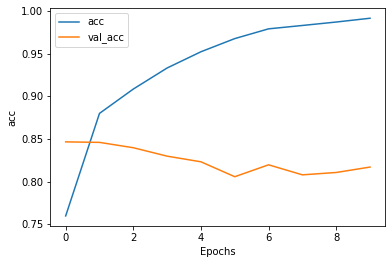

In [0]:
plot_graphs(history, 'acc')

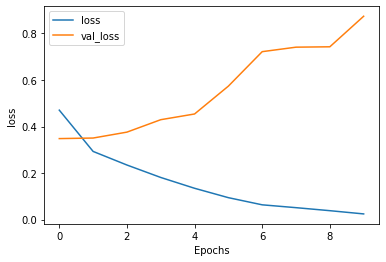

In [0]:
plot_graphs(history, 'loss')

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


##Test the model

In [0]:
sentences = ['I really think this is amazing. honest.',
             "it's wasting time.",
             'the best of this year!',
             'totally junk',
             'read the book, instead of going to cinema',
             'your kids will love it!',
             'the effect is cheap.']
sequence = tokenizer.texts_to_sequences(sentences)
print(sequence)
r = model.predict(pad_sequences(sequence, maxlen = max_length, padding = 'post', truncating = trunc_type))
for u, v in list(zip(sentences, r)):
    rating = 'Good' if v[0] > 0.5 else 'Bad'
    print(f'{u} → {rating}')

[[11, 68, 105, 12, 7, 491, 1216], [103, 3165, 60], [2, 120, 5, 12, 281], [495, 2615], [337, 2, 274, 306, 5, 168, 6, 436], [131, 358, 81, 119, 10], [2, 970, 7, 716]]
I really think this is amazing. honest. → Good
it's wasting time. → Good
the best of this year! → Good
totally junk → Good
read the book, instead of going to cinema → Bad
your kids will love it! → Good
the effect is cheap. → Good


##Visualize embeddings

In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

visit website: projector.tensorflow.org